In [1]:
import pickle
import random
import argparse
import numpy as np
from rdkit import Chem
import rdkit.Chem.QED
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import torch
from torch.utils.data import DataLoader
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.data.dataset import ecloud_dataset
from coati.common.util import batch_indexable
from coati.math_tools.altair_plots import roc_plot
from coati.generative.coati_purifications import force_decode_valid_batch, purify_vector, embed_smiles
from coati.generative.embed_altair import embed_altair

In [ ]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.backends.cudnn.deterministic = True

arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--mode', choices=['basic', 'near', 'regression', 'dynamics'], \
    default='basic',help='Generation mode')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--model', type=str, default = 'models/ecloud_augmented_37.pkl')
arg_parser.add_argument('--dataset', type=str, default='data/ecloud_coati_demo.pt')
arg_parser.add_argument('--smiles', type=str, default='data/demo.smi')
arg_parser.add_argument('--output', type=str, default='0423_near_mol4_30.txt')
arg_parser.add_argument('--noise', type=float, default=0.3)
args = arg_parser.parse_args([])
setup_seed(args.seed)


In [ ]:
def basic_generation(args):
    DEVICE = torch.device(args.device)
    encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
        freeze=True,
        device=DEVICE,
        # model parameters to load.
        doc_url=args.model,
    )

    dataset = ecloud_dataset(args.dataset)
    epoch_iter = DataLoader(dataset = dataset, batch_size = 1, shuffle=False)
    out=[]
    all=0
    for batch_data in epoch_iter:
        eclouds = torch.Tensor(batch_data["eclouds"]).to(torch.float).to(DEVICE)
        smiles_list = encoder.eclouds_to_2d_batch(eclouds, tokenizer, '[SMILES]', noise_scale=args.noise)
        for s in smiles_list:
            all += 1
            if Chem.MolFromSmiles(s)!=None:
                out.append(s)

    if out!=[]:
        with open(args.output,'w') as f:
            for s in out:
                f.write(s+'\n')

    print('valid: ', len(out), len(out)/all)

In [ ]:
DEVICE = torch.device(args.device)
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.model,
)

In [ ]:
dataset = ecloud_dataset(args.dataset)
epoch_iter = DataLoader(dataset = dataset, batch_size = 1, shuffle=False)
out=[]
all=0

In [ ]:
dataset[0]['eclouds'].shape

In [ ]:
for batch_data in epoch_iter:
    break

In [ ]:
eclouds = torch.Tensor(batch_data["eclouds"]).to(torch.float).to(DEVICE)

In [ ]:
smiles_list = encoder.eclouds_to_2d_batch(eclouds, tokenizer, '[SMILES]', noise_scale=0)
Chem.MolFromSmiles(smiles_list[0])

In [ ]:
raw_tokens = batch_data['raw_tokens'].tolist()[0]

In [ ]:
smiles = tokenizer.decode(raw_tokens, special=keep_special)

In [ ]:
smiles

In [ ]:
Chem.MolFromSmiles(smiles)

In [ ]:
batch_data['raw_tokens'].shape

In [ ]:
Chem.MolFromSmiles(smiles_list[0])

In [ ]:
h_clip = encoder.encode_eclouds(eclouds_batch)
noise_scale = args.noise
h_clip += torch.normal(
    mean=torch.zeros_like(h_clip), std=noise_scale * torch.ones_like(h_clip)
)

h_token = encoder.point_clip_to_special_tokens(h_clip)
fill_in_from = "[SMILES]"
suffstr = ""
token_prebatch = tokenizer.tokenize_text(
    "[CLIP][UNK]" + fill_in_from + suffstr, pad=False
)

inv_temp = 2.0
k = 100

generation = encoder.xformer.generate_top_k_with_inj_batch(
    prefix=token_prebatch,
    stop_token=tokenizer.stop_token,
    inv_temp=inv_temp,
    k=k,
    pad_token=tokenizer.pad_token,
    inj_token=tokenizer.unk_token,
    inj_payload=h_token,
)

keep_special = False
token_out = generation[0]
smiles = tokenizer.decode(token_out, special=keep_special)

In [ ]:
keep_special = False
token_out = generation[0]
smiles = tokenizer.decode(token_out, special=keep_special)

In [ ]:
token_out

In [ ]:
Chem.MolFromSmiles(smiles)

In [ ]:

for batch_data in epoch_iter:
    eclouds = torch.Tensor(batch_data["eclouds"]).to(torch.float).to(DEVICE)
    smiles_list = encoder.eclouds_to_2d_batch(eclouds, tokenizer, '[SMILES]', noise_scale=args.noise)
    for s in smiles_list:
        all += 1
        if Chem.MolFromSmiles(s)!=None:
            out.append(s)


In [ ]:
# case 2 

In [ ]:
dataset = ecloud_dataset(args.dataset)
ref = dataset[4] # only choose one for test
ecloud = torch.Tensor(ref["eclouds"]).to(torch.float).to(DEVICE).unsqueeze(0)
raw_token = torch.Tensor(ref["raw_tokens"]).to(torch.float).to(DEVICE).unsqueeze(0)
num_to_gen = 50

In [ ]:
raw_smi = tokenizer.decode(ref["raw_tokens"].tolist(), special=False)

In [ ]:
smiles_near_ref = encoder.ecloud_and_token_to_2d_batch(
eclouds = ecloud,
tokens = raw_token.long(),
tokenizer = tokenizer,
num_to_gen = num_to_gen, 
noise_scale = args.noise
)

In [ ]:
eclouds = ecloud
tokens = raw_token.long()

In [ ]:
h_ecloud = encoder.encode_eclouds(eclouds).repeat(num_to_gen, 1)
h_smiles = encoder.encode_tokens(tokens, tokenizer).repeat(num_to_gen, 1)
if noise_scale > 0:
    h_smiles += torch.normal(
        mean=torch.zeros_like(h_smiles), std=noise_scale * torch.ones_like(h_smiles)
    )
point_clip_token = encoder.point_clip_to_special_tokens(h_ecloud)
smiles_clip_token = encoder.point_clip_to_special_tokens(h_smiles)
clip_token = torch.where(
    (torch.rand((h_ecloud.shape[0],), device=eclouds.device) > 0.5)
    .unsqueeze(-1)
    .repeat(1, point_clip_token.shape[-1]),
    point_clip_token,
    smiles_clip_token,
)

In [ ]:
random_token = (torch.rand((h_ecloud.shape[0],), device=eclouds.device) > 0.5).unsqueeze(-1).repeat(1, point_clip_token.shape[-1])

In [ ]:
tokenizer.unk_token

In [ ]:
clip_token = torch.where(random_token,point_clip_token,smiles_clip_token)

In [ ]:
# case 3
DEVICE = torch.device(args.device)
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.model,
)

with open(args.smiles) as f:
    smiles = [line.strip('\n') for line in f][:10000]
random.shuffle(smiles)
subset = [{"smiles": s, "source": "demo_mols"} for s in smiles]

In [ ]:
embed_and_score_in_batches_regression(subset, encoder, tokenizer)

In [ ]:
records = subset
batch_size=128
batch_iter = batch_indexable(records, batch_size)

In [ ]:
num_batches = len(records) // batch_size

In [ ]:
for i, batch in enumerate(batch_iter):
    break

In [ ]:
smiles_field="smiles"
batch_mols = [Chem.MolFromSmiles(row[smiles_field]) for row in batch]
batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]

In [ ]:
batch_tokens = torch.tensor(
    [
        tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
        if s != "*"
        else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
        for s in batch_smiles
    ],
    device=encoder.device,
    dtype=torch.int,
)

In [ ]:
batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)

In [ ]:
batch_logp = [rdkit.Chem.Crippen.MolLogP(m) for m in batch_mols]
batch_qed = [rdkit.Chem.QED.qed(m) for m in batch_mols]

In [ ]:
from part3_gen_cases import embed_and_score_in_batches_regression
embed_and_score_in_batches_regression(subset, encoder, tokenizer)

In [ ]:
y_field = "logp" 
qed_model, qed_res = basic_due(
    subset,
    x_field="emb_smiles",
    y_field=y_field,
    save_as="regression_"+y_field+".pkl",
    continue_training=True,
    steps=1e4,
    random_seed=args.seed
    )

In [ ]:
DEVICE = torch.device(args.device)
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.model,
)

In [ ]:
with open(args.smiles) as f:
    smiles = [line.strip('\n') for line in f]
init_mols = [{"smiles": s} for s in smiles[:3]]

In [ ]:
subset = [{"smiles": s, "source": "demo_mols"} for s in smiles[:1000]] # only for load model

In [ ]:
from part3_gen_cases import embed_and_score_in_batches_regression

embed_and_score_in_batches_regression(subset, encoder, tokenizer)

In [ ]:
def get_qed(v):
    return qed_model(v.unsqueeze(0)).mean

def get_logp(v):
    return logp_model(v.unsqueeze(0)).mean

def logp_penalty(v):
    """
    Penalize logP > 5. Loss is squared to make it smooth.
    """
    return torch.pow(4 * torch.nn.functional.relu(get_logp(v) - 5.0), 2.0)

qed_model, _ = basic_due(
    subset,
    x_field="emb_smiles",
    y_field="qed",
    load_as="regression_qed.pkl",
    continue_training=False,
    random_seed=args.seed
    )
logp_model, _ = basic_due(
    subset,
    x_field="emb_smiles",
    y_field="logp",
    load_as="regression_logp.pkl",
    continue_training=False,
    random_seed=args.seed
    )

In [ ]:
nsteps = 2000
meta_traj_no_binding = []

In [ ]:
k = 0
rec = init_mols[k]

init_emb_vec = embed_smiles(rec["smiles"], encoder, tokenizer).to(DEVICE)  
objective_fcn = lambda X: -10 * get_qed(X)  # the constraints below will be added to this.
bump_radius=0.125 * 4
bump_height=80.0 * 16
constraint_functions={
    "logp_p": logp_penalty
}  # enforced to == 0 by lagrange multipliers.
log_functions={
    "logp": get_logp,
    "qed": get_qed,
}  # These log functions will get appended to the history list-dict returned.
nsteps=nsteps
save_traj_history=f"./meta_traj_no_binding_{k}.pkl"

In [ ]:
vec = torch.nn.Parameter(init_emb_vec.to(encoder.device))
vec.requires_grad = True

In [ ]:
constraint_functions

In [ ]:
params = [vec]
for _ in constraint_functions.keys():
    params.append(torch.nn.Parameter(100 * torch.ones_like(vec[:1])))

In [ ]:
optimizer = torch.optim.SGD(params, lr=2e-3)

In [ ]:
smiles = force_decode_valid_batch(init_emb_vec, encoder, tokenizer)


In [ ]:
history = [
    {
        "emb": vec.flatten().detach().cpu().numpy(),
        "name": 0,
        "smiles": smiles,
        "library": "opt",
        "activity": objective_fcn(vec).item(),
        **{
            c: constraint_functions[c](vec).detach().cpu().numpy()
            for c in constraint_functions
        },
        **{c: log_functions[c](vec).detach().cpu().numpy() for c in log_functions},
    }
]

In [ ]:
def bump_potential(V, bumps=[], radius=0.125, height=80.0, vec_dim=256):
    """
    Explore space by using gaussian bump potentials when the vector isn't
    changing a lot.
    """

    if len(bumps) < 1:
        return torch.zeros(1, device=V.device)

    bump_potential = (
        height
        * (
            (
                torch.distributions.multivariate_normal.MultivariateNormal(
                    torch.stack(bumps, 0).to(V.device),
                    radius * torch.eye(vec_dim).to(V.device),
                ).log_prob(V)
                + (vec_dim / 2) * (np.log(2 * torch.pi) + np.log(radius))
            ).exp()
        ).sum()
    )

    return bump_potential

In [ ]:
bump_radius

In [ ]:
Chem.MolFromSmiles(smiles)

In [ ]:
Chem.MolFromSmiles(init_mols[0]['smiles'])

In [ ]:
# no bumps are initialized.
nsteps = 2000


bumps = []
last_bump = 0
save_every = 25
project_every = 15
for k in range(nsteps):
    if k % project_every == 0 and k > 0:
        vec.data = 0.4 * vec.data + 0.6 * purify_vector(
            vec.data, encoder, tokenizer, n_rep=50
        )

    optimizer.zero_grad()
    activity = objective_fcn(vec)

    constraint_values = []
    for f in constraint_functions.keys():
        constraint_values.append(constraint_functions[f](vec))
    if len(constraint_values):
        constraint_term = torch.sum(torch.concat(constraint_values))
    else:
        constraint_term = torch.zeros_like(activity)

    # add a bump_term to the loss (=0 if no bumps).
    bump_term = bump_potential(vec, bumps, radius=bump_radius, height=bump_height)

    loss = activity + constraint_term + bump_term
    loss.backward()  # retain_graph=True)

    if k % save_every == 0:
        # Try to decode the vector here into a molecule!.
        smiles = force_decode_valid_batch(vec, encoder, tokenizer)

        history.append(
            {
                "emb": vec.flatten().detach().cpu().numpy(),
                "name": k,
                "smiles": smiles,
                "library": "opt",
                "loss": loss.detach().cpu().item(),
                "activity": activity.detach().cpu().item(),
                "bump_term": bump_term.detach().cpu().item(),
                "const_term": constraint_term.detach().cpu().item(),
                **{
                    c: log_functions[c](vec).detach().cpu().item()
                    for c in log_functions
                },
            }
        )

        v1 = history[-1]["emb"]
        v2 = history[-2]["emb"]
        s1 = history[-1]["smiles"]
        s2 = history[-2]["smiles"]

        # build log string
        log_str = f"{k}: dV {np.linalg.norm(v1-v2):.3e} "
        to_log = ["loss", "activity", "bump_term", "const_term"] + list(
            log_functions.keys()
        )
        for l in to_log:
            log_str = log_str + f"{l}:{history[-1][l]:.2f} "

        if (
            ((v1 * v2).sum() / (np.linalg.norm(v1) * np.linalg.norm(v2)) > 0.85)
            and (k - last_bump > 25)
        ) or (s1 == s2 and k > 50):
            print("adding bump ", smiles)
            last_bump = k
            new_bump = torch.from_numpy(v1).to(device=vec.device)
            bumps.append(new_bump)

        if save_traj_history is not None:
            # save trajectory to file
            with open(save_traj_history, "wb") as f:
                pickle.dump(history, f)

        print(log_str)

    optimizer.step()

In [57]:
traj = history
for r in traj:
    r["library"] = "opt_" + str(k)
meta_traj_no_binding.extend(traj)

In [60]:
from part3_gen_cases import embed_and_score_in_batches
rdkit_scores = {
    "qed_rdkit": rdkit.Chem.QED.qed,
    "logp_rdkit": rdkit.Chem.Crippen.MolLogP,
    "mol_wt_rdkit": rdkit.Chem.Descriptors.ExactMolWt,
}
model_scores = {"qed_model": get_qed, "logp_model": get_logp}
embed_and_score_in_batches(
    meta_traj_no_binding, encoder, tokenizer, 
    rdkit_scores=rdkit_scores, model_scores=model_scores
)

Embedding and scoring iterable from smiles.
batch: 0/0


/tmp/ipykernel_792190/3115518039.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  plt.scatter(


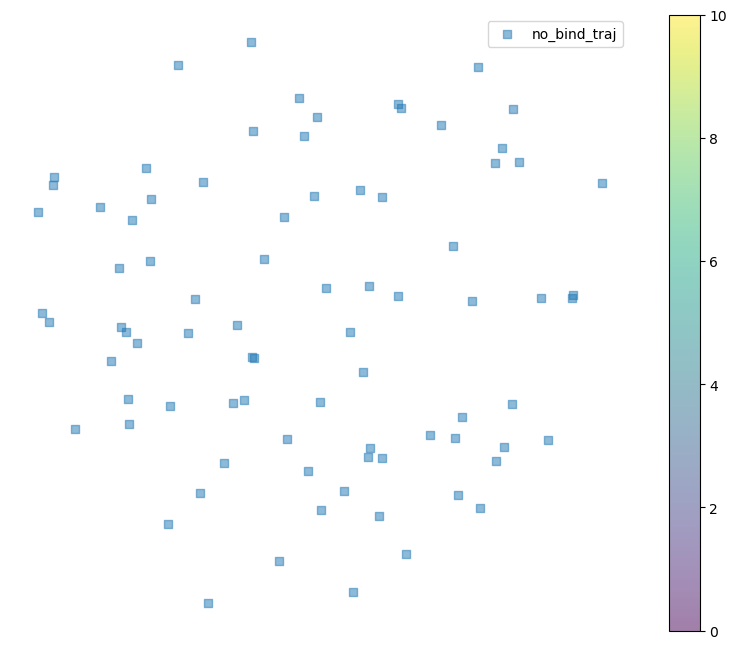

In [62]:
# save 1
for r in meta_traj_no_binding:
    r["library"] = "meta_qed"
to_score = meta_traj_no_binding 
df = pd.DataFrame(to_score)
embs = np.stack(df["emb_smiles"].values.tolist(), 0)
X_embedded = TSNE(n_components=2, learning_rate=100, init="random").fit_transform(embs)
df.loc[:, "X"] = X_embedded[:, 0]
df.loc[:, "Y"] = X_embedded[:, 1]
norm = matplotlib.colors.Normalize(vmin=0, vmax=5.0)
plt.figure(figsize=(10, 8))
plt.scatter(
    df[df.library == "meta_qed"].X,
    df[df.library == "meta_qed"].Y,
    #c=df[df.library == "meta_qed"].pic50_model,
    norm=norm,
    marker="s",
    cmap="plasma",
    alpha=0.5,
    label="no_bind_traj",
)
plt.clim(0, 10.0)
plt.legend()
plt.colorbar()
plt.axis("off")
plt.savefig("trajs_tsne.pdf", dpi=300, bbox_inches="tight")


In [63]:
# save 2
chart = embed_altair(
df,
tooltip_fields=["smiles", "mol_index", "logp_rdkit", "qed_rdkit"],
selector_field="library",
quantity="qed_rdkit",
image_tooltip=True,
emb_field="emb_smiles",
smiles_field="smiles",
width=1024,
height=768,
)
chart.save("meta_dyn_trajs.html")
# save 3
images = []
for traj in meta_traj_no_binding:
    try:
        k = traj["name"]
        qed = traj["qed_model"]
        logp = traj["logp_model"]
        images.append(
            Chem.Draw.MolToImage(
                Chem.MolFromSmiles(traj["smiles"]),
                legend=f"k {k} qed {qed:.2f} logp {logp:.2f}",
            )
        )
    except:
        pass

/home/haotian/software/miniconda3/envs/ecloud/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/haotian/software/miniconda3/envs/ecloud/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


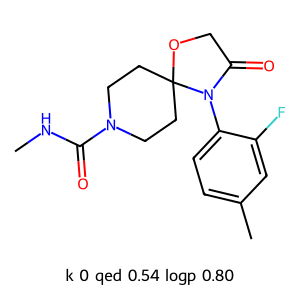

In [75]:
images[1]

In [64]:
images[0].save(
    "qed_meta_example_2k_steps.gif",
    save_all=True,
    append_images=images[1:],
    optimize=False,
    duration=120,
    loop=0,
)